In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

from keras.models import model_from_json
import cv2, os
from keras.layers import Flatten
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
train_dir = r"../Shashank/dataset/ImageEmotion (85-15)/train"
test_dir = r"../Shashank/dataset/ImageEmotion (85-15)/test"

SEED = 12
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64
momentum = 0.9
EPOCHS = 500
#FINE_TUNING_EPOCHS = 30
LR = 0.001
NUM_CLASSES = 8
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Amusement', 'Anger', 'Awe', 'Contentment', 'Disgust', 'Excitement', 'Fear', 'Sadness']
CLASS_LABELS_EMOJIS = ["🥳", "😡", "😯", "😌", "🤢" ,"🤩", "😱" , "😔" ]

In [4]:
#preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rotation_range= 10,
                                   validation_split = 0
                                  )
test_datagen = ImageDataGenerator(validation_split = 0
                                  )

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 18559 images belonging to 8 classes.
Found 3277 images belonging to 8 classes.


In [5]:
emotion_model1 = tf.keras.applications.densenet.DenseNet201(input_shape=(224,224,3), include_top= False,
                                                                 weights= 'imagenet')
emotion_model2 = tf.keras.applications.resnet.ResNet101(input_shape=(224,224,3), include_top= False,
                                                                 weights= 'imagenet')

preprocess_fn1 = tf.keras.applications.densenet.preprocess_input 
preprocess_fn2 = tf.keras.applications.resnet.preprocess_input 

def emotion_model1_feature_extractor(inputs):
    y = emotion_model1(inputs)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
    return x, y

def emotion_model2_feature_extractor(inputs):
    y = emotion_model2(inputs)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
    return x, y

# def mainobject_model_feature_extractor(inputs):
#     y = mainobject_model(inputs)
#     y = tf.keras.layers.GlobalAveragePooling2D()(y)
#     x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
#     return x, y

def classifier(features):
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', 
                              name='classification')(features)
    
    return x
        
def final_model(inputs, emotion_model1, emotion_model2, mainobject_model):
    x, emotion_features1 = emotion_model1(preprocess_fn1(inputs)*1./255)
    x, emotion_features2 = emotion_model2(preprocess_fn2(inputs)*1./255)
    mainobject_features = mainobject_model(preprocess_fn2(inputs)*1./255)
    
    merged_features = tf.concat([mainobject_features, 1.0*emotion_features1, 1.0*emotion_features2], axis=1)
    classification_output = classifier(merged_features)
    
    return classification_output

def define_compile_model(emotionweights1_path, emotionweights2_path):
    
    inputs = tf.keras.layers.Input(shape=(224,224,3))
    
    emotion_model1 = tf.keras.Model(inputs= inputs, outputs= emotion_model1_feature_extractor(inputs))
    emotion_model1.load_weights(emotionweights1_path)
    emotion_model2 = tf.keras.Model(inputs= inputs, outputs= emotion_model2_feature_extractor(inputs))
    emotion_model2.load_weights(emotionweights2_path)
    mainobject_model = tf.keras.applications.resnet.ResNet101(input_shape=(224,224,3), include_top= True, 
                                                                 weights='imagenet')
    mainobject_model.trainable = False
    
    classification_output = final_model(inputs, emotion_model1, emotion_model2, mainobject_model) 
    model = tf.keras.Model(inputs= inputs, outputs= classification_output)
    model.compile(optimizer=tf.keras.optimizers.SGD(0.001), 
                loss='categorical_crossentropy',
                metrics = ['acc'])
  
    return model

2022-10-18 23:38:57.568463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 23:38:57.568620: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 23:38:57.615244: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/stud1/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-10-18 23:38:57.615255: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://w

In [6]:
emotionweights1_path = r'../Shashank/h5 files/DenseNet201-010-0.780538-0.641440.h5'
emotionweights2_path = r'../Shashank/h5 files/ResNet101-009-0.762864-0.650595.h5'
model = define_compile_model(emotionweights1_path, emotionweights2_path)
model.load_weights(r'Idea2_DenseNet201+ResNet101_100-100-003-0.767714-0.659139.h5')

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 tf.nn.bias_add (TFOpLambda)    (None, 224, 224, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 224, 224, 3)  0          ['input_3[0][0]']          

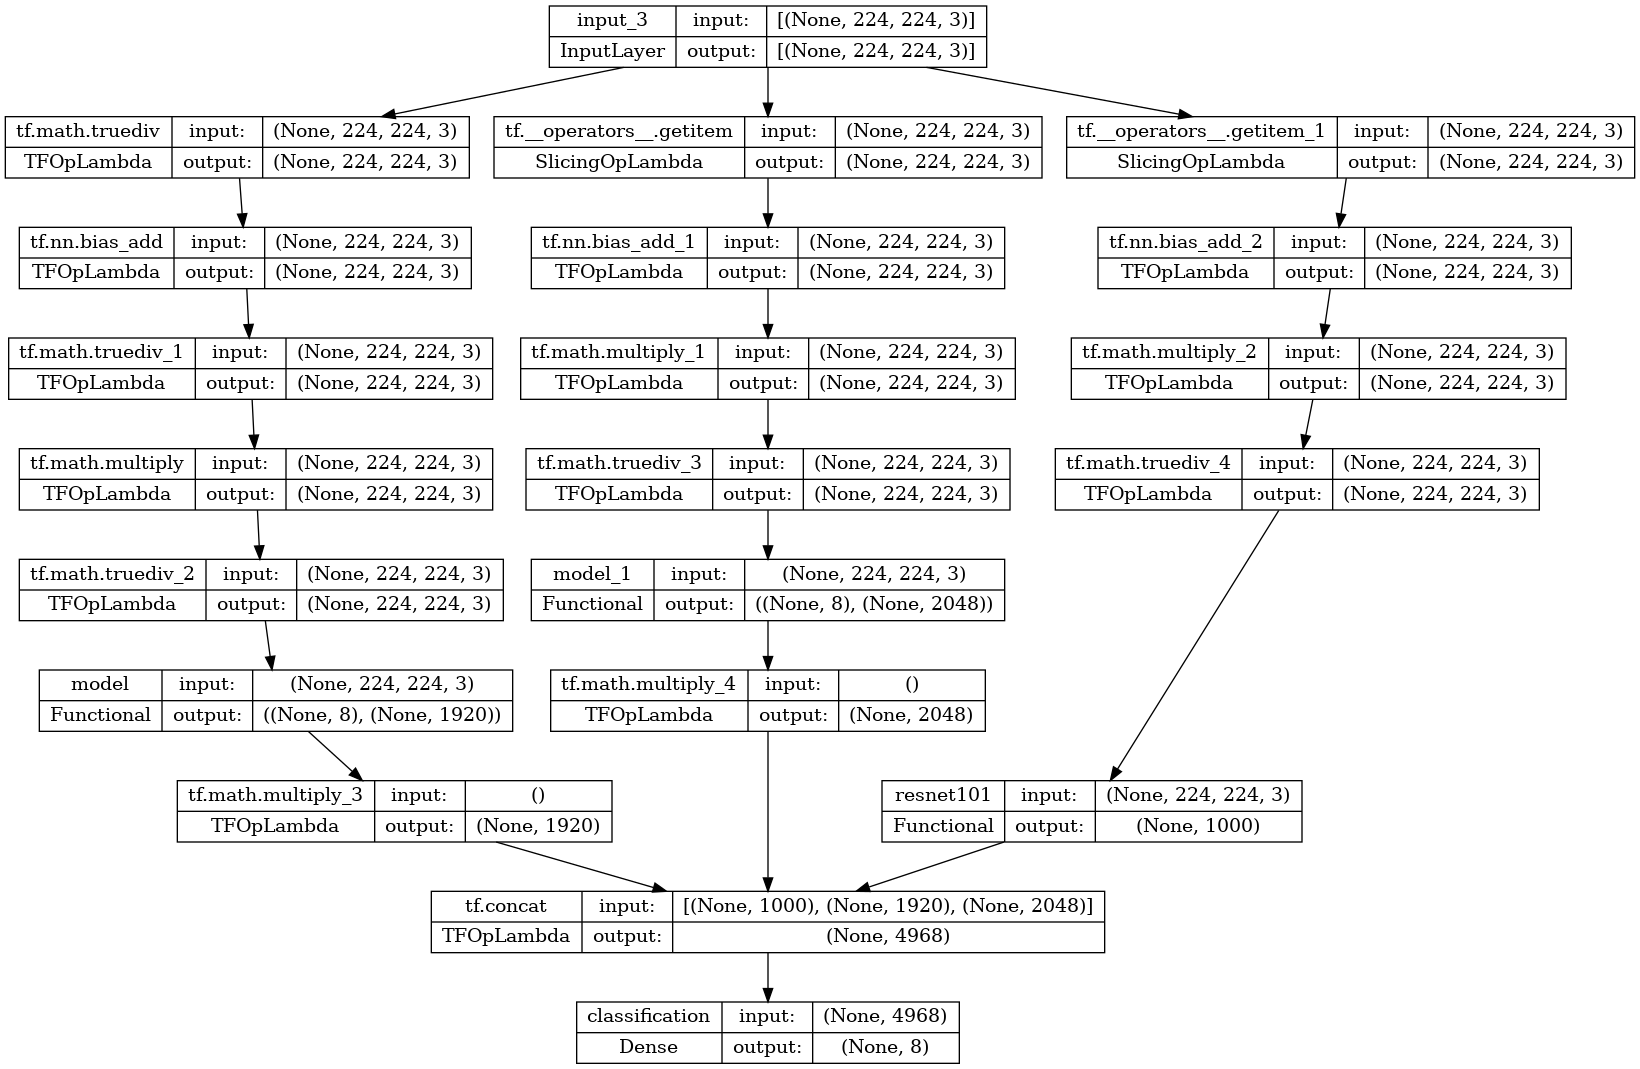

In [7]:
#for plotting model
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)


from keras.utils.vis_utils import plot_model    
plot_model(model, to_file='model_i1.png', show_shapes=True, show_layer_names=True)

In [8]:
#for saving weights after every epoch
checkpoint = ModelCheckpoint('Idea2_DenseNet201+ResNet101_100-100-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, 
                        monitor='val_acc',save_best_only=True, mode='auto') 
#earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto')

In [9]:
#training the model
history = model.fit(train_generator,
            batch_size = BATCH_SIZE,
            epochs= 100,
            validation_data = test_generator,
            callbacks= [checkpoint]
            ) 

history = pd.DataFrame(history.history)

Epoch 1/100
290/290 [==============================] - ETA: 0s - loss: 0.6352 - acc: 0.7825 
Epoch 1: val_acc improved from -inf to 0.65914, saving model to Idea2_DenseNet201+ResNet101_100-100-001-0.782531-0.659139.h5
290/290 [==============================] - 3523s 12s/step - loss: 0.6352 - acc: 0.7825 - val_loss: 1.0241 - val_acc: 0.6591
Epoch 2/100
290/290 [==============================] - ETA: 0s - loss: 0.6085 - acc: 0.7945 
Epoch 2: val_acc improved from 0.65914 to 0.66067, saving model to Idea2_DenseNet201+ResNet101_100-100-002-0.794547-0.660665.h5
290/290 [==============================] - 3506s 12s/step - loss: 0.6085 - acc: 0.7945 - val_loss: 1.0241 - val_acc: 0.6607
Epoch 3/100
290/290 [==============================] - ETA: 0s - loss: 0.5866 - acc: 0.7997 
Epoch 3: val_acc did not improve from 0.66067
290/290 [==============================] - 3502s 12s/step - loss: 0.5866 - acc: 0.7997 - val_loss: 1.0250 - val_acc: 0.6597
Epoch 4/100
290/290 [=============================

KeyboardInterrupt: 

In [9]:
json_model = model.to_json()
with open('Idea2_DenseNet201+ResNet101_100-100.json', 'w') as json_file:
    json_file.write(json_model)
print('Saved model.')

Saved model.
